In [1]:
from pyspark.sql import SparkSession 

# Initialising Spark Session
spark = SparkSession \
    .builder \
    .appName("Python Spark - Number of Spotify Songs for each Main Artist") \
    .getOrCreate()

In [2]:
# Used for stopping spark session
#spark.stop()

In [3]:
# Constants defining streaming parammeters
TOPIC = 'groupB04.spotifyartists'
STARTING_OFFSETS = "latest"

In [4]:
# Starting spark data frame
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "node1:9092") \
  .option("subscribe", TOPIC) \
  .option("startingOffsets",STARTING_OFFSETS) \
  .option("failOnDataLoss", "false")\
  .option("checkpointLocation", "/tmp/b6") \
  .load() 

In [5]:
# Checking if everything works by printing the schema of the data
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [6]:
from pyspark.sql.functions import get_json_object, concat, lit, desc, window
from pyspark.sql.types import *
from pyspark.sql import functions as f

# Since our data is in CSV format, we get each variable by spliting our message by ','
split_col = f.split(df['value'], ',')

# Adding new columns to our data frame
df = df \
         .withColumn('UUID', split_col.getItem(0)) \
         .withColumn('artist', split_col.getItem(1))

# Converting our dataframe to values in correct types
converted = df \
    .selectExpr("UUID", "artist", "timestamp")\
    .select([\
            df["UUID"].cast(StringType()), \
            df["artist"].cast(StringType()).alias("Artist"), \
            df["timestamp"].cast(TimestampType()) \
            ])

In [7]:
window_duration = "60 seconds"
watermark_duration = "30 seconds"

groupdf = converted \
    .select("UUID", "artist", "timestamp") \
    .withWatermark("timestamp", watermark_duration) \
    .groupby(window("timestamp", window_duration), "Artist") \
    .count().alias("count_result") \
    .sort(desc("window"), desc("count")) \
    .limit(10)

In [8]:
%matplotlib inline
from pyspark.sql import SparkSession
from IPython import display
import matplotlib.pyplot as plt

# Defining the function that will be used for representing our data in real time (incrementaly)
def show_plot_and_df(epoch_frame, epoch_id):
    if (epoch_frame.count()==0):
        print("Waiting for new messages...")
        return
    # Printing plot with approprate labels
    epoch_frame.toPandas().plot(kind='bar', x='Artist', y='count')
    display.clear_output(wait=True)
    plt.title("Number of Spotify Songs for a given Artist")
    plt.ylabel("Number of Songs")
    plt.xlabel("Artist")
    plt.show()
    # Printing dataframe
    epoch_frame.show()
    # Printing current iteration
    print("Current Epoch: " + str(epoch_id))
    


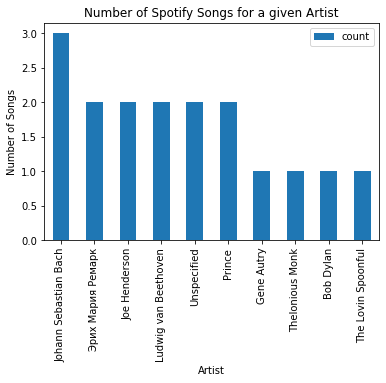

+--------------------+--------------------+-----+
|              window|              Artist|count|
+--------------------+--------------------+-----+
|[2020-12-29 20:47...|Johann Sebastian ...|    3|
|[2020-12-29 20:47...|   Эрих Мария Ремарк|    2|
|[2020-12-29 20:47...|       Joe Henderson|    2|
|[2020-12-29 20:47...|Ludwig van Beethoven|    2|
|[2020-12-29 20:47...|         Unspecified|    2|
|[2020-12-29 20:47...|              Prince|    2|
|[2020-12-29 20:47...|          Gene Autry|    1|
|[2020-12-29 20:47...|     Thelonious Monk|    1|
|[2020-12-29 20:47...|           Bob Dylan|    1|
|[2020-12-29 20:47...|  The Lovin Spoonful|    1|
+--------------------+--------------------+-----+

Current Epoch: 16


In [ ]:
# Defining some parammeters
processingTime = "5 Seconds"
outputMode = "complete"

plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['font.sans-serif'] = ['SimHei'] # for Chinese font (https://github.com/matplotlib/matplotlib/issues/15062)

# Finally, showing the data which updates every processingTime seconds
df = groupdf \
    .writeStream \
    .outputMode(outputMode) \
    .foreachBatch(show_plot_and_df) \
    .trigger(processingTime=processingTime) \
    .start() \
    .awaitTermination()

In [ ]:
# After finish we can stop spark session
spark.stop()